<h1><span style="color: #5D3FD3;"> Objective 1a: Image Classifier using CNN</span></h1>

<br>

|Name|Class|Admin Number|
|:----:|:----:|:----:|
|Muhammad Fitri Amir bin Abdullah|DAAA/FT/2B/06|2222811|


<br>

In this task, I aim to implement an image classifier using a Convolutional Neural Network in order to classify a dataset that contains 15 different types of vegetables. There are some steps given that I will need to adhere to such as: 
- converting the image into grayscale (1 channel instead of 3)
- making 2 model for 2 inputs, 31x31 pixels and 128x128 pixels, NOT 224 (the original pixels given in the dataset).

Looking at the metadata of the dataset given, here's some useful information:
- Total 15 Classes of 3000 images; means that this is a multi-class classification task.
- Each class contain 200 images
- Size of each image is 224*224 and images are in *.jpg format.

<hr>

In [2]:
!pip install --quiet keras-tuner numpy tqdm wandb pandas tensorflow-addons graphviz matplotlib seaborn plotly scikit-learn visualkeras

In [3]:
pip install --quiet tensorflow

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install opencv-python

   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.6 MB 991.0 kB/s eta 0:00:39
   ---------------------------------------- 0.4/38.6 MB 5.0 MB/s eta 0:00:08
   - -------------------------------------- 1.1/38.6 MB 8.7 MB/s eta 0:00:05
   -- ------------------------------------- 1.9/38.6 MB 11.2 MB/s eta 0:00:04
   -- ------------------------------------- 2.8/38.6 MB 12.6 MB/s eta 0:00:03
   --- ------------------------------------ 3.6/38.6 MB 13.4 MB/s eta 0:00:03
   ---- ----------------------------------- 4.3/38.6 MB 13.8 MB/s eta 0:00:03
   ----- ---------------------------------- 5.1/38.6 MB 14.1 MB/s eta 0:00:03
   ------ --------------------------------- 5.8/38.6 MB 14.3 MB/s eta 0:00:03
   ------ --------------------------------- 6.5/38.6 MB 14.4 MB/s eta 0:00:03
   ------- -------------------------------- 7.3/38.6 MB 14.6 MB/s eta 0:00:03
   -------- ------------------------------- 8.0/38.6 MB 14.7 MB/s eta 0:0

In this project, I will be using wandb in order to monitor the weights and biases assigned.

In [5]:
pip install wandb

Note: you may need to restart the kernel to use updated packages.


<h2><span style="color: #5D3FD3;"> 
1. Importing Packages + Utility Functions 
</span>
</h2>

In [6]:
import numpy as np
import pandas as pd
import datetime
import os, time, math, datetime, warnings
import cv2

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import seaborn as sns
import plotly as px
import plotly.graph_objects as go
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical, plot_model
from functools import reduce, wraps
from sklearn.metrics import classification_report,accuracy_score, confusion_matrix
from tensorflow.keras.models import load_model
from wandb.keras import WandbCallback

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input, concatenate, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.optimizers import Adam, SGD

custom  = {"axes.edgecolor" : "white", 
            "grid.linestyle": "dashed",
            "grid.color": "gray"
            }
sns.set_style("whitegrid", rc = custom)

C:\Users\Fitri\AppData\Local\Temp\ipykernel_30916\1089273868.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### 1a) Checking that GPU is used

In [2]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9733031977881273389
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5819596800
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8820356743260559987
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [3]:
!nvidia-smi

Fri Nov 24 19:16:24 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.23                 Driver Version: 536.23       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050      WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   42C    P2              21W / 130W |   1894MiB /  8192MiB |      7%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
pip install --quiet opencv-python

Note: you may need to restart the kernel to use updated packages.


### 1d) Initialising Wandb

In [18]:
import wandb
from wandb.keras import WandbCallback
wandb.init()
# When prompted, please enter this as my API key: 0e7bca4b5f9244ca51966ad8adf08bbfff4ac0ad

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: fenriyx (sp-work). Use `wandb login --relogin` to force relogin


### Utility Functions

In [7]:
def read_pic(dataset_path, filename):
    images = []
    labels = []
    folder_path = os.path.join(dataset_path, filename)
    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        for image_file in os.listdir(label_path):
            image_path = os.path.join(label_path, image_file)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, (128, 128))
            image = image.astype('float32')
            images.append(image)
            labels.append(label)
    #         images = np.array(images)
    #         labels = np.array(labels)
    return images, labels

In [8]:
from sklearn.preprocessing import LabelEncoder
def preprocess(train, test, val):

    # unpack data
    X_train, y_train = train
    X_test, y_test = test
    X_val, y_val = val

    # normalize pixel values
    X_train = X_train / 255.0
    X_test = X_test / 255.0
    X_val = X_val / 255.0

    # Reshape the data (assuming 128x128 images)
    input_shape = (128, 128, 1)  # Adjust based on your image size and channels
    X_train = X_train.reshape(X_train.shape[0], *input_shape)
    X_test = X_test.reshape(X_test.shape[0], *input_shape)
    X_val = X_val.reshape(X_val.shape[0], *input_shape)

    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train)
    y_test = label_encoder.transform(y_test)
    y_val = label_encoder.transform(y_val)

    # one hot encode labels
    y_train = to_categorical(y_train, num_classes = len(np.unique(y_train)))
    y_test = to_categorical(y_test, num_classes= len(np.unique(y_test)))
    y_val = to_categorical(y_val, num_classes= len(np.unique(y_val)))

    return (X_train, y_train), (X_test, y_test), (X_val, y_val)


In [9]:
def plot_lc(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    ax[0].plot(loss, label='Training Loss')
    ax[0].plot(val_loss, label='Validation Loss')
    ax[0].set_title('Cross Entropy Loss', fontsize=16)
    ax[0].set_xlabel('Epochs', fontsize=14)
    ax[0].set_ylabel('Loss', fontsize=14)
    ax[0].legend()

    ax[1].plot(acc, label='Training Accuracy')
    ax[1].plot(val_acc, label='Validation Accuracy')
    ax[1].set_title('Accuracy', fontsize=16)
    ax[1].set_xlabel('Epochs', fontsize=14)
    ax[1].set_ylabel('Accuracy', fontsize=14)
    ax[1].legend()

    plt.tight_layout()
    plt.show()

In [10]:
def get_loss_acc(models):
    
    losses = {}
    accuracies = {}
    
    for model in models:
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val), verbose=0, epochs=100, batch_size=128)
        losses[model.name] = history.history['val_loss']
        accuracies[model.name] = history.history['val_accuracy']
        
    loss_df = pd.DataFrame(losses)  
    acc_df = pd.DataFrame(accuracies)
    
    return loss_df, acc_df

In [11]:
# Learning rate schedule function
def lr_schedule(epoch):
    """
    Returns a learning rate based on the epoch number.
    """
    learning_rate = 1e-3  # Initial learning rate

    if epoch > 50:
        learning_rate *= 1e-1
    elif epoch > 30:
        learning_rate *= 5e-1

    return learning_rate

In [12]:
#Print loss and accuracy text after loading file
def print_loss_acc(history):
    final_train_loss = history.history['loss'][-1]
    final_train_accuracy = history.history['accuracy'][-1]
        
    final_val_loss = history.history['val_loss'][-1]
    final_val_accuracy = history.history['val_accuracy'][-1]

    print(f'Final Training Loss: {final_train_loss:.4f}')
    print(f'Final Training Accuracy: {final_train_accuracy:.4f}')

    print(f'Final Validation Loss: {final_val_loss:.4f}')
    print(f'Final Validation Accuracy: {final_val_accuracy:.4f}')

In [13]:
def print_training_history(history):
    # Print training and validation losses
    print("Training Loss:", history.history['loss'][-1])
    print("Validation Loss:", history.history['val_loss'][-1])

    # Print training and validation accuracies
    print("Training Accuracy:", history.history['accuracy'][-1])
    print("Validation Accuracy:", history.history['val_accuracy'][-1])

<h2>
<span style="color: #5D3FD3;">
2. Exploratory Data Analysis
</h2>

### 2a. Importing dataset and preparing test/train set

In [14]:
dataset_path = "Datasets/Dataset for CA1 part A/"

# Load training images and labels
train_images, train_labels = read_pic(dataset_path, "train")
X_train = np.array(train_images)
y_train = np.array(train_labels)

# Load test images and labels
test_images, test_labels = read_pic(dataset_path, "test")
X_test = np.array(test_images)
y_test = np.array(test_labels)

val_images, val_labels = read_pic(dataset_path, "validation")
X_val = np.array(val_images)
y_val = np.array(val_labels)

### 2b. Checking the dataset for errors and outliers

In this portion I will be checking:
- All pixels >=0 and <=255
- No missing values for any pixels
- Total number of classes
- Names of classes
- Class distribution
- Blank images

<h5>Checking Pixel values</h5>

In [11]:
print(f"Min pixel value in x_train: {np.amin(X_train)}")
print(f"Max pixel value in x_train: {np.amax(X_train)}")
print(f"Min pixel value in x_test: {np.amin(X_test)}")
print(f"Max pixel value in x_test: {np.amax(X_test)}")

Min pixel value in x_train: 0.0
Max pixel value in x_train: 255.0
Min pixel value in x_test: 0.0
Max pixel value in x_test: 255.0


<h5>Checking for missing values</h5>

In [12]:
print(f"Any missing values in x_train: {np.isnan(X_train).any()}")
print(f"Any missing values in x_test: {np.isnan(X_test).any()}")

Any missing values in x_train: False
Any missing values in x_test: False


<h5>Checking all the classes</h5>

In [13]:
print(f"Classes in y_train: {len(np.unique(y_train))}")
print(f"Names of classes: {np.unique(y_train)}")

Classes in y_train: 15
Names of classes: ['Bean' 'Bitter_Gourd' 'Bottle_Gourd' 'Brinjal' 'Broccoli' 'Cabbage'
 'Capsicum' 'Carrot' 'Cauliflower' 'Cucumber' 'Papaya' 'Potato' 'Pumpkin'
 'Radish' 'Tomato']


<h5>Ensuring that pictures are grayscale</h5>

In [14]:
print(X_train[0].shape)

(128, 128)


<h5>Sample Images</h5>

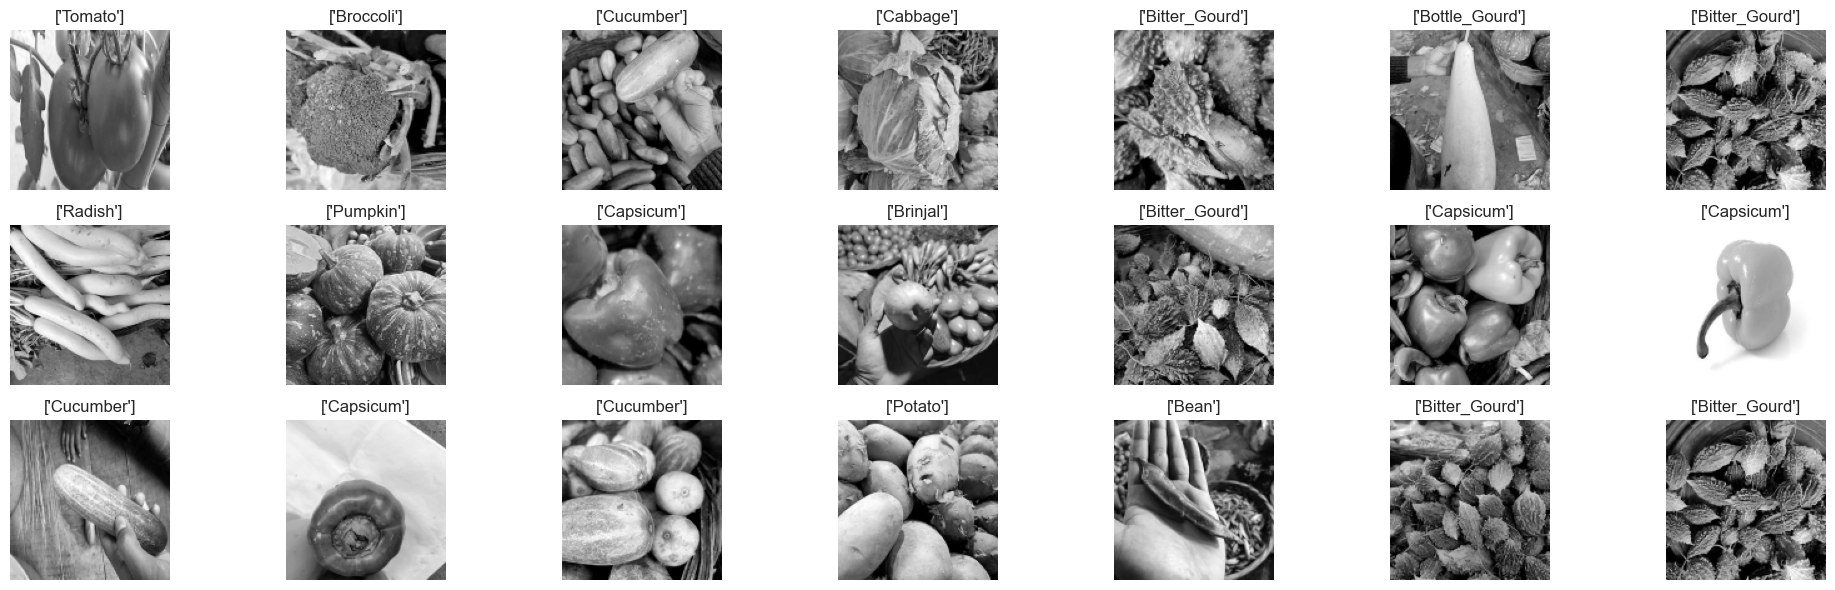

In [13]:
#Checking if the data was imported correctly

fig = plt.figure(figsize=(20, 6))
for i in range(1, 22):
    randn = int(np.random.random() * len(X_train))
    ax = fig.add_subplot(3, 7, i)
    ax.imshow(X_train[randn], cmap='gray')  # Use cmap='gray' to display grayscale images
    ax.set_title([y_train.flatten()[randn]])
    ax.axis('off')

plt.tight_layout()
plt.show()


Label Bean makes up 8.64% of the training data
Label Bitter_Gourd makes up 7.98% of the training data
Label Bottle_Gourd makes up 4.88% of the training data
Label Brinjal makes up 9.61% of the training data
Label Broccoli makes up 8.31% of the training data
Label Cabbage makes up 5.57% of the training data
Label Capsicum makes up 3.89% of the training data
Label Carrot makes up 2.84% of the training data
Label Cauliflower makes up 6.50% of the training data
Label Cucumber makes up 8.99% of the training data
Label Papaya makes up 6.27% of the training data
Label Potato makes up 4.18% of the training data
Label Pumpkin makes up 9.02% of the training data
Label Radish makes up 2.75% of the training data
Label Tomato makes up 10.58% of the training data


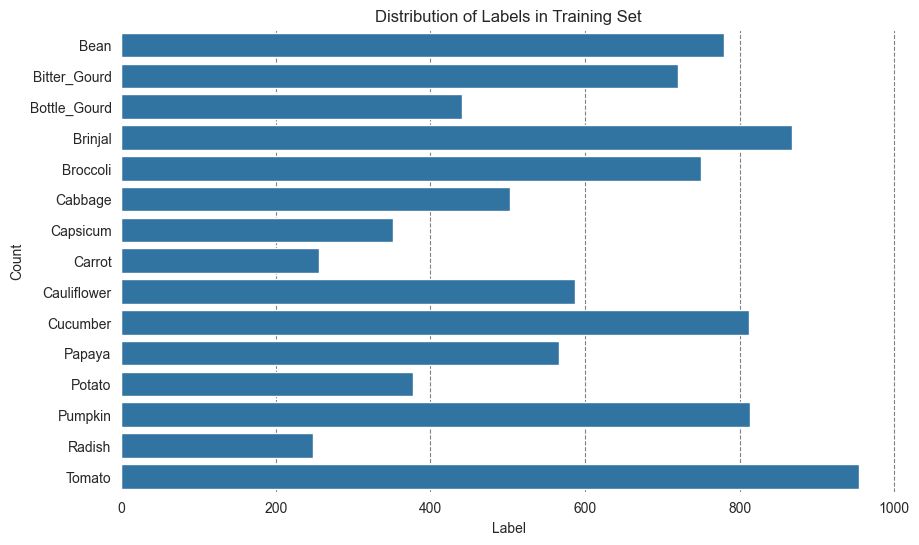

In [14]:
labels = np.unique(y_train)
# print(labels)
# map labels to their names
# y_train_label = np.array([labels[i] for i in y_train])

for label in labels:
    #Count percentage of each label
    percentage = (np.sum(y_train == label) / y_train.shape[0]) * 100
    print(f"Label {label} makes up {percentage:.2f}% of the training data")

#use seaborn plot percentage
plt.figure(figsize=(10, 6))
sns.countplot(y_train)
plt.title("Distribution of Labels in Training Set")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

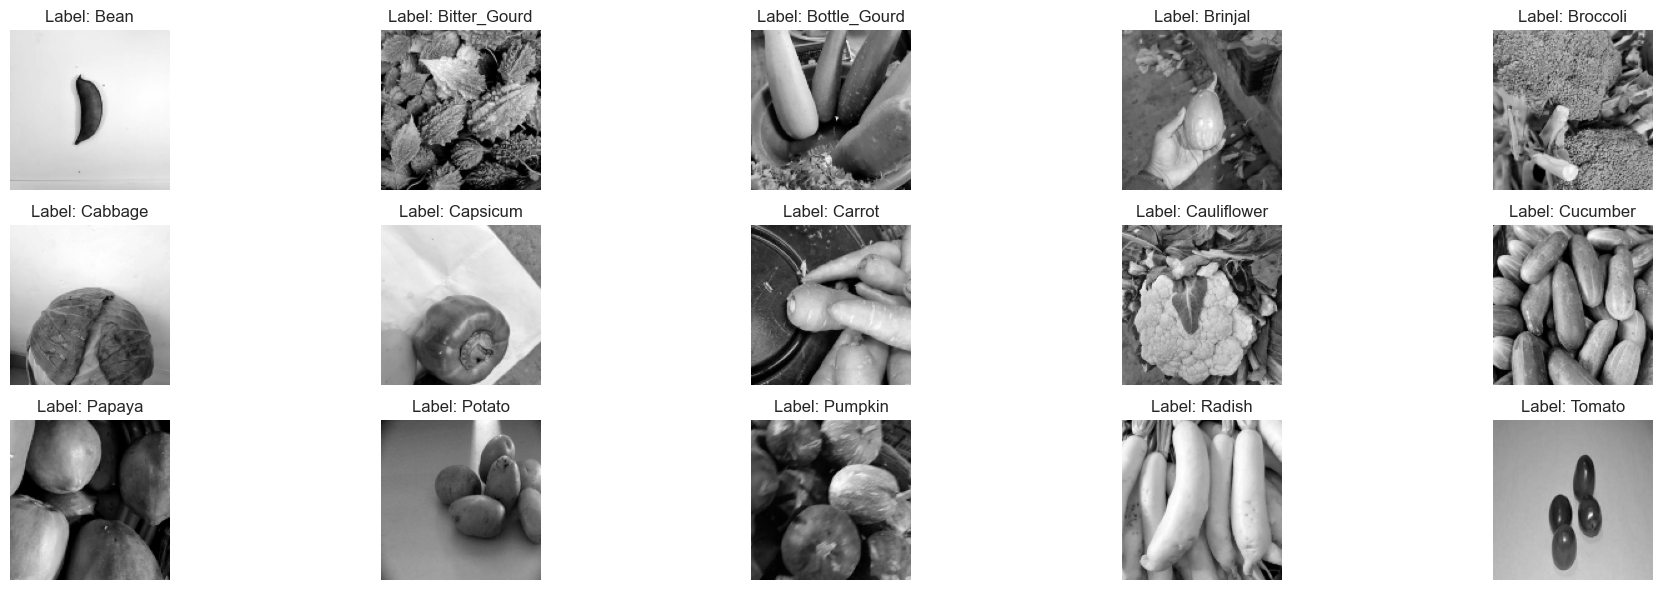

In [15]:
fig = plt.figure(figsize=(20, 6))

for i, label in enumerate(np.unique(y_train), start=1):
    index = np.where(y_train == label)[0][0]
    ax = fig.add_subplot(3, 5, i)  
    
    ax.imshow(X_train[index], cmap='gray')
    ax.set_title(f"Label: {label}")
    ax.axis('off')

plt.tight_layout()
plt.show()


#### Final Dataset observations:

Through the checks, we can see that the image was imported correctly. There are no glitched pixels, all of the pixels are within 0 and 255 (the shape of X_train is 128 by 128, if they were colored it would be 128 by 128 by 3)

<h2>
<span style="color: #5D3FD3;">
3. Data Preprocessing/Feature Engineering
</span>
</h2>

Firstly, I will be normalising the pixel values such that they range from 0 - 1 instead of 0 - 255. This is because it makes the machine more efficent when the range of numbers are smaller, due to the features being on a similar scale. If we do not do so, the network learns weights from features that are from different scales, and the large feature may 'drown' out the small features. Not rescaling the pixels can introduce the problem of exploding gradients, due to the high range of pixels.

The CNN model also requires 3D input, which means that the values need to be reshaped to 128x128x1.

#### 3a) Transforming x and y values / Reshaping 

In [15]:
# Using util function to firstly label encode, then use to_categorical to assign one hot encoding through
# binary vectors. Next, reshape 

(X_train, y_train), (X_test, y_test), (X_val, y_val) = preprocess((X_train, y_train), (X_test, y_test), (X_val, y_val))

#### 3b) Data augmentation

Data augmentation is a method to reduce the variance of a model by imposing random transformations on the data for training. Data augmentation is a method to reduce the variance of a model by imposing random transformations on the data for training. Some types of data augmentation include:

- Flipping
- Cropping
- Rotating
- Scaling
- Shearing

For this task, I will be using rotation, horizontal flip, and zoom. From the visualisation of the dataset earlier, we observed that there are a lot of variations in all the types of vegetables. It includes pictures from different angles, at different sizes as well as of different orientations. I feel that these are the most prominent types of "distortions" in the photo. Therefore, these are the ways that I chose the types of augmentation that I am applying.

I will also be setting the batch size to 64. I feel that this is a good value as I am able to trade a little bit of accuracy and risk slight overfitting for a better run time, which allows me to judge the model's performance better.

In [14]:
batch_size = 64

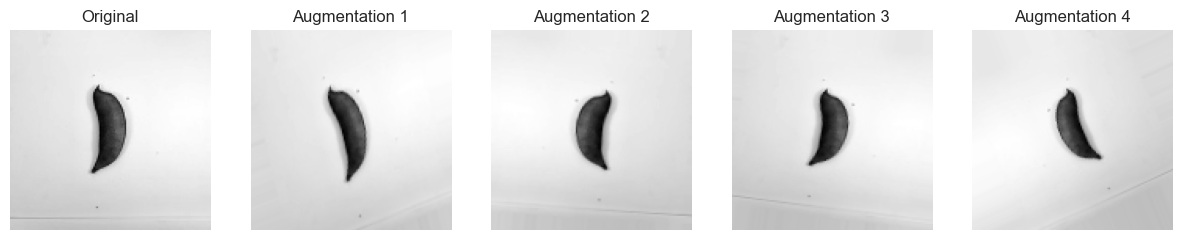

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True,
    zoom_range=0.2,
)

# Visualize the original and augmented images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

# Original image
axes[0].imshow(X_train[0].reshape(128, 128), cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')

# Augmented images
for i in range(1, 5):
    augmented_image = datagen.random_transform(X_train[0])  # Apply random transformations
    axes[i].imshow(augmented_image.reshape(128, 128), cmap='gray')
    axes[i].set_title(f'Augmentation {i}')
    axes[i].axis('off')

plt.show() 

## 4) Baseline Modelling

### Implementing a baseline CNN

<img src = "Images/BaselineCNN.png">

Generally, this is what a Convolutional Neural Network(CNN) looks like. 

In this portion of the task, I will be going through step by step on how I will be building my CNN, by explaining each layer as well as the different functions I will use to build the model.

<h4> Input Layer </h4>
This is where the image starts being processed. In the neural network of image processing, it generally represents the pixel matrix of the image.

<h4> Convolution Layer </h4>

<center> 
<img src = "Images/ConvolutionalLayer.gif" width="35%" height="35%"> 
<hr>
An animation on how the convolutional layer extract the various features from the input.
</center>


Convolutional layers are the core building blocks of CNNs. They apply convolutional operations to the input data, which helps in learning spatial hierarchies of features. By sliding the filter over the input image, the dot product is taken between the filter and the parts of the input image with respect to the size of the filter.

<h4> Activation Layer </h4>

Activation functions introduce non-linearity into the model, enabling it to learn complex relationships in the data. In a neural network without activation functions, the output of each layer is a linear combination of its inputs. Mathematically, if 
x is the input to a layer, and  W is the weight matrix, and b is the bias vector, the output y is given by:

<center>

$$ y = Wx + b $$

</center>

However, with the introductions of activation functions, it determines the output of a neuron based on its input, and this non-linear transformation enables the model to learn and represent intricate patterns, capturing features like edges, textures, and more abstract concepts. Some of the more common activation functions include: ReLU, Sigmoid, Tanh (Hyperbolic Tangent), Softmax.\

Generally, ReLU 

<h4> Pooling Layer </h4>
The pooling layer helps with reducing the dimensions of the data, which helps to avoid overfitting as having to much specifity of the features in different fruits will cause it to generalise instead of classify. When a model learns the training data too well, capturing noise and specific patterns that are not representative of the broader underlying relationships in the data. This lack of generalization can lead to poor performance on new, unseen data because the model has essentially memorized the training set rather than learning the true underlying patterns.

<h4> Fully Connected Layer </h4>

<h4> Batch normalization </h4>

Batch Norm reduces the amount of shifts of distribution for hidden unit values, no matter how the values from previous unit shifts. Batch normalisation is scaled by the mean/variance of the mini-batch, which adds some noise to the values; thus having some regularization effect.

However, Batch Normalisation(BN), should not juxtapose the dropout layer. Previously, I found out that the dropout layer 


<h4> Dropout Layer </h4>

In [27]:
import wandb
from wandb.keras import WandbCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Flatten, Dense

input_shape = (128, 128, 1)
 
# Create a sequential model
model = Sequential()

num_classes = 15
model.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(128))

model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(datagen.flow(X_train, y_train, batch_size=64),
                    epochs=100,
                    validation_data=(X_val, y_val),
                    callbacks=[WandbCallback(save_model=True)])
model.summary()

Epoch 1/100
  6/142 [>.............................] - ETA: 14s - loss: 19.4600 - accuracy: 0.0911WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0213s vs `on_train_batch_end` time: 0.0832s). Check your callbacks.


142/142 [==============================] - 15s 104ms/step - loss: 3.9874 - accuracy: 0.2641 - val_loss: 1.9954 - val_accuracy: 0.3587
Epoch 2/100
142/142 [==============================] - 13s 93ms/step - loss: 1.8245 - accuracy: 0.4319 - val_loss: 1.7817 - val_accuracy: 0.4447
Epoch 3/100
142/142 [==============================] - 13s 90ms/step - loss: 1.6346 - accuracy: 0.4827 - val_loss: 1.6324 - val_accuracy: 0.4803
Epoch 4/100
142/142 [==============================] - 11s 80ms/step - loss: 1.5293 - accuracy: 0.5136 - val_loss: 2.0393 - val_accuracy: 0.3563
Epoch 5/100
142/142 [==============================] - 11s 77ms/step - loss: 1.4833 - accuracy: 0.5338 - val_loss: 1.4063 - val_accuracy: 0.5693
Epoch 6/100
142/142 [==============================] - 12s 87ms/step - loss: 1.3960 - accuracy: 0.5623 - val_loss: 1.6482 - val_accuracy: 0.4893
Epoch 7/100
142/142 [==============================] - 11s 78ms/step - loss: 1.3538 - accuracy: 0.5695 - val_loss: 1.3557 - val_accuracy: 0.5

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231124_221803-o3oy7sxk\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231124_221803-o3oy7sxk\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231124_221803-o3oy7sxk\files\model-best)... Done. 0.4s


142/142 [==============================] - 15s 108ms/step - loss: 1.1482 - accuracy: 0.6393 - val_loss: 1.2339 - val_accuracy: 0.6407
Epoch 19/100
142/142 [==============================] - ETA: 0s - loss: 1.0972 - accuracy: 0.6623

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231124_221803-o3oy7sxk\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231124_221803-o3oy7sxk\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231124_221803-o3oy7sxk\files\model-best)... Done. 0.4s


142/142 [==============================] - 15s 109ms/step - loss: 1.0972 - accuracy: 0.6623 - val_loss: 1.2211 - val_accuracy: 0.6307
Epoch 20/100
142/142 [==============================] - ETA: 0s - loss: 1.0814 - accuracy: 0.6619

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231124_221803-o3oy7sxk\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231124_221803-o3oy7sxk\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231124_221803-o3oy7sxk\files\model-best)... Done. 0.4s


142/142 [==============================] - 14s 98ms/step - loss: 1.0814 - accuracy: 0.6619 - val_loss: 1.2201 - val_accuracy: 0.6457
Epoch 21/100
142/142 [==============================] - 13s 92ms/step - loss: 1.0655 - accuracy: 0.6678 - val_loss: 1.8467 - val_accuracy: 0.4893
Epoch 22/100
142/142 [==============================] - 12s 86ms/step - loss: 1.0486 - accuracy: 0.6722 - val_loss: 1.8845 - val_accuracy: 0.5120
Epoch 23/100
142/142 [==============================] - 12s 85ms/step - loss: 1.0750 - accuracy: 0.6685 - val_loss: 1.4115 - val_accuracy: 0.6040
Epoch 24/100
142/142 [==============================] - 12s 81ms/step - loss: 1.0538 - accuracy: 0.6746 - val_loss: 1.4259 - val_accuracy: 0.5857
Epoch 25/100
142/142 [==============================] - ETA: 0s - loss: 1.0429 - accuracy: 0.6773

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231124_221803-o3oy7sxk\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231124_221803-o3oy7sxk\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231124_221803-o3oy7sxk\files\model-best)... Done. 0.4s


142/142 [==============================] - 13s 91ms/step - loss: 1.0429 - accuracy: 0.6773 - val_loss: 1.2192 - val_accuracy: 0.6423
Epoch 26/100
142/142 [==============================] - ETA: 0s - loss: 1.0217 - accuracy: 0.6838

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231124_221803-o3oy7sxk\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231124_221803-o3oy7sxk\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231124_221803-o3oy7sxk\files\model-best)... Done. 0.4s


142/142 [==============================] - 14s 101ms/step - loss: 1.0217 - accuracy: 0.6838 - val_loss: 1.0950 - val_accuracy: 0.6837
Epoch 27/100
142/142 [==============================] - 14s 99ms/step - loss: 1.0144 - accuracy: 0.6791 - val_loss: 1.7205 - val_accuracy: 0.5137
Epoch 28/100
142/142 [==============================] - 13s 90ms/step - loss: 1.0213 - accuracy: 0.6799 - val_loss: 1.2550 - val_accuracy: 0.6433
Epoch 29/100
142/142 [==============================] - 13s 88ms/step - loss: 1.0172 - accuracy: 0.6879 - val_loss: 1.1103 - val_accuracy: 0.6893
Epoch 30/100
142/142 [==============================] - 13s 91ms/step - loss: 1.0415 - accuracy: 0.6766 - val_loss: 1.2287 - val_accuracy: 0.6463
Epoch 31/100
142/142 [==============================] - 13s 92ms/step - loss: 0.9555 - accuracy: 0.7038 - val_loss: 1.4280 - val_accuracy: 0.5937
Epoch 32/100
142/142 [==============================] - ETA: 0s - loss: 0.9693 - accuracy: 0.6986

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231124_221803-o3oy7sxk\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231124_221803-o3oy7sxk\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231124_221803-o3oy7sxk\files\model-best)... Done. 0.4s


142/142 [==============================] - 16s 111ms/step - loss: 0.9693 - accuracy: 0.6986 - val_loss: 1.0667 - val_accuracy: 0.6923
Epoch 33/100
142/142 [==============================] - 13s 89ms/step - loss: 0.9762 - accuracy: 0.6952 - val_loss: 1.2752 - val_accuracy: 0.6500
Epoch 34/100
142/142 [==============================] - 11s 78ms/step - loss: 0.9636 - accuracy: 0.6961 - val_loss: 1.2475 - val_accuracy: 0.6503
Epoch 35/100
142/142 [==============================] - 7s 50ms/step - loss: 0.9569 - accuracy: 0.7012 - val_loss: 1.1941 - val_accuracy: 0.6610
Epoch 36/100
142/142 [==============================] - 14s 101ms/step - loss: 0.9400 - accuracy: 0.7035 - val_loss: 1.5009 - val_accuracy: 0.5877
Epoch 37/100
142/142 [==============================] - 14s 95ms/step - loss: 1.0038 - accuracy: 0.6891 - val_loss: 1.3341 - val_accuracy: 0.6333
Epoch 38/100
142/142 [==============================] - 14s 97ms/step - loss: 0.9383 - accuracy: 0.7026 - val_loss: 1.2208 - val_accurac

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231124_221803-o3oy7sxk\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231124_221803-o3oy7sxk\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231124_221803-o3oy7sxk\files\model-best)... Done. 0.5s


142/142 [==============================] - 12s 86ms/step - loss: 0.7796 - accuracy: 0.7545 - val_loss: 0.9685 - val_accuracy: 0.7457
Epoch 82/100
142/142 [==============================] - 10s 69ms/step - loss: 0.7966 - accuracy: 0.7458 - val_loss: 1.0133 - val_accuracy: 0.7370
Epoch 83/100
142/142 [==============================] - 10s 68ms/step - loss: 0.7545 - accuracy: 0.7592 - val_loss: 1.2997 - val_accuracy: 0.6720
Epoch 84/100
142/142 [==============================] - 10s 71ms/step - loss: 0.7742 - accuracy: 0.7584 - val_loss: 1.1594 - val_accuracy: 0.7060
Epoch 85/100
142/142 [==============================] - 10s 73ms/step - loss: 0.7596 - accuracy: 0.7592 - val_loss: 1.3233 - val_accuracy: 0.6653
Epoch 86/100
142/142 [==============================] - 10s 69ms/step - loss: 0.7671 - accuracy: 0.7570 - val_loss: 1.2401 - val_accuracy: 0.6770
Epoch 87/100
142/142 [==============================] - 9s 62ms/step - loss: 0.7646 - accuracy: 0.7616 - val_loss: 1.1589 - val_accuracy:

In [32]:
model.save("baseModel.h5")

In [ ]:
from tensorflow.keras.models import load_model
loaded_model = load_model("baseModel.h5")

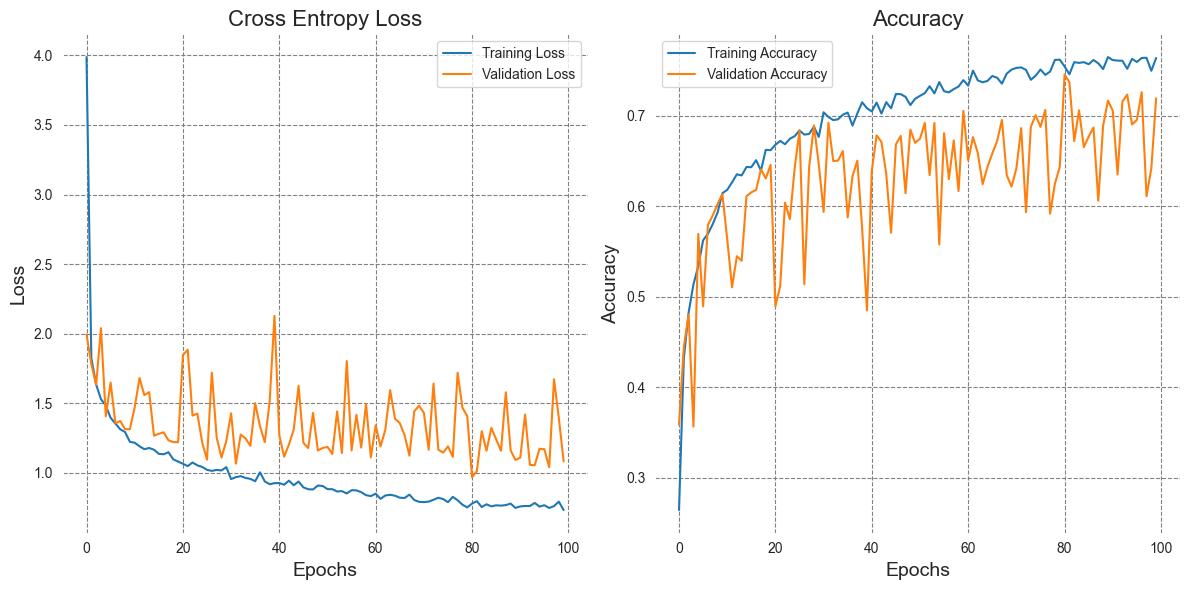

In [31]:
plot_lc(history)

In [21]:
baseline = load_model("baseModel.h5")
loss, accuracy = baseline.evaluate(X_test, y_test, verbose=0)

print_loss_acc(baseline, X_test, y_test)

Loss: 1.0556364059448242
Accuracy: 0.7226666808128357


#### Observations:

As we can see, the model is overfitting. We can infer that as the training loss is reaching to as close as 0 but the validation loss is constantly increasing. This may mean that instead of memorising, the model is actually generalising. This could be because of the lack of layers. With lesser layers(also known as lower depth), the capacity of the data will be lower.  This means that it will not be able to take in more advanced/complex patterns that may be available in the photos of the dataset.

However, we have to be careful when adding too many layers. From research, I can tell that it is very computationally expensive (ie it will take more time to run and make). From these sources, I also realised that there is *NO* optimal amount of layers; its more of a trial and error. I realised that our data is relatively small, and from multiple different projects online, I would guess that it would take 2 to 5 (at the VERY most) layers in order to train the model optimally without risking it to be computationally expensive.

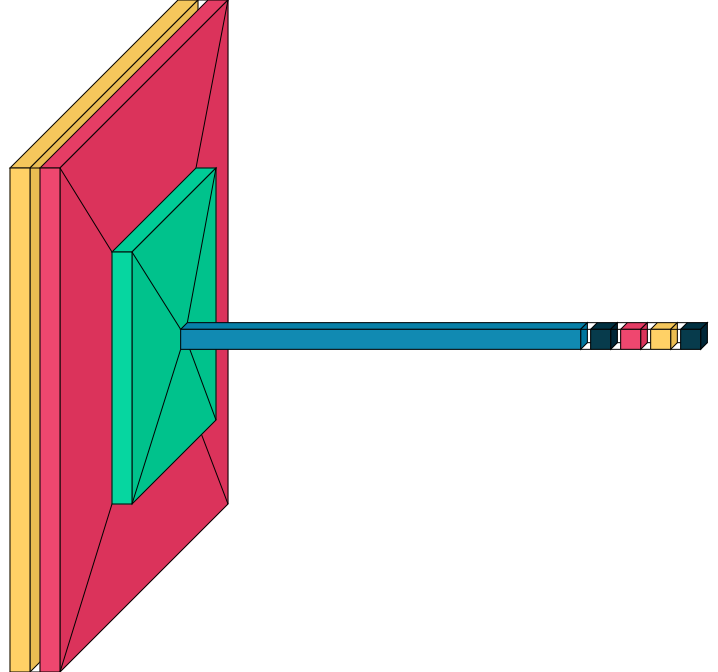

In [21]:
import visualkeras
visualkeras.layered_view(model)

## 6. Model Improvement

Theres some options available to model improvements, with their own explanations:

- Testing it without data augmentation. From linkedin: 
>"Data augmentation can also introduce biases or errors in the data, especially if the transformations are not realistic or consistent with the data distribution. Data augmentation can also have diminishing returns, as adding more transformations or more augmented data may not lead to significant improvements or may even degrade the performance."

It could be very possible that my earlier assumptions about data augmentations were wrong, and I would have to test it out to verify the results. I will avoid data augmentation if removing it helps reduce overfitting or generally improves the loss/accuracy not to the point of overfitting.

- Learning rate scheduling
>A desirable learning rate is one that’s low enough so that the network converges to something useful but high enough so that it can be trained in a reasonable amount of time. When we schedule the learning rate, we allow the model to vary the speed of its learning. If the learning rate is too low, the computation time would take far too long. However, if it is too high, it will cause the model to generalize the pattern that it finds. 

<center>
<img src = "Images/LearningRate.png">
<hr>
Gauge of a good learning rate
</center>

- Regularisation (L1/L2)

Regularization is a technique used to prevent overfitting in machine learning models. However, it is not our main purpose here. Looking at both L1(Lasso) and L2(Ridge) regularisation methods, there is a clear difference. L1 takes the absolute value of the magnitude of coefficients, while L2 takes the square of the magnitude of the coefficients. This means that L1 works better in feature selection, but L2 gives a more equal weightage on the lesser weighted features. In my opinion, we should use L2. This is because there are many features in the variety of vegetables in the dataset. This means that we should not exclude them and hence, I feel that L2 is the most suitable in this context.

- Adding additional Layers

<h4>6a) Removing Data Augmentation</h4>

To make this fair, I will need to use the exact same model and amount of layers as the original model. This is because letting other factors (such as model complexity) affect the accuracy will not give a clear result whether the model does better or worse than using the model with data augmentation.

To compare, I will look at the fitting of the model; this is because data augmentation assists with reducing overfitting.

In [18]:
import wandb
from wandb.keras import WandbCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Flatten, Dense
input_shape = (128, 128, 1)

model = Sequential()

num_classes = 15
model.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#Dont use data augmentation(datagen.flow)
history = model.fit(X_train, y_train,
                    epochs=100,
                    validation_data=(X_val, y_val),
                    callbacks=[WandbCallback(save_model=True)])
model.summary()
model.save("noAugmentModel.h5")

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/100
282/283 [============================>.] - ETA: 0s - loss: 2.5137 - accuracy: 0.1876

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_024124-tudsvojd\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_024124-tudsvojd\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_024124-tudsvojd\files\model-best)... Done. 0.4s


283/283 [==============================] - 15s 31ms/step - loss: 2.5134 - accuracy: 0.1877 - val_loss: 2.2712 - val_accuracy: 0.2723
Epoch 2/100
280/283 [============================>.] - ETA: 0s - loss: 1.9689 - accuracy: 0.3474

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_024124-tudsvojd\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_024124-tudsvojd\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_024124-tudsvojd\files\model-best)... Done. 0.4s


283/283 [==============================] - 8s 28ms/step - loss: 1.9693 - accuracy: 0.3470 - val_loss: 1.8440 - val_accuracy: 0.4333
Epoch 3/100
282/283 [============================>.] - ETA: 0s - loss: 1.6878 - accuracy: 0.4392

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_024124-tudsvojd\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_024124-tudsvojd\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_024124-tudsvojd\files\model-best)... Done. 0.4s


283/283 [==============================] - 8s 27ms/step - loss: 1.6878 - accuracy: 0.4390 - val_loss: 1.7041 - val_accuracy: 0.4740
Epoch 4/100
280/283 [============================>.] - ETA: 0s - loss: 1.4954 - accuracy: 0.4915

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_024124-tudsvojd\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_024124-tudsvojd\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_024124-tudsvojd\files\model-best)... Done. 0.4s


283/283 [==============================] - 8s 28ms/step - loss: 1.4969 - accuracy: 0.4914 - val_loss: 1.5528 - val_accuracy: 0.5317
Epoch 5/100
281/283 [============================>.] - ETA: 0s - loss: 1.3287 - accuracy: 0.5524

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_024124-tudsvojd\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_024124-tudsvojd\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_024124-tudsvojd\files\model-best)... Done. 0.4s


283/283 [==============================] - 8s 28ms/step - loss: 1.3286 - accuracy: 0.5524 - val_loss: 1.5110 - val_accuracy: 0.5503
Epoch 6/100
282/283 [============================>.] - ETA: 0s - loss: 1.1714 - accuracy: 0.6020

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_024124-tudsvojd\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_024124-tudsvojd\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_024124-tudsvojd\files\model-best)... Done. 0.4s


283/283 [==============================] - 8s 28ms/step - loss: 1.1713 - accuracy: 0.6020 - val_loss: 1.4305 - val_accuracy: 0.5577
Epoch 7/100
281/283 [============================>.] - ETA: 0s - loss: 0.9857 - accuracy: 0.6641

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_024124-tudsvojd\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_024124-tudsvojd\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_024124-tudsvojd\files\model-best)... Done. 0.4s


283/283 [==============================] - 8s 28ms/step - loss: 0.9848 - accuracy: 0.6645 - val_loss: 1.3493 - val_accuracy: 0.6057
Epoch 8/100
282/283 [============================>.] - ETA: 0s - loss: 0.8736 - accuracy: 0.6999

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_024124-tudsvojd\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_024124-tudsvojd\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_024124-tudsvojd\files\model-best)... Done. 0.4s


283/283 [==============================] - 8s 28ms/step - loss: 0.8740 - accuracy: 0.6998 - val_loss: 1.2464 - val_accuracy: 0.6327
Epoch 9/100
283/283 [==============================] - 6s 20ms/step - loss: 0.7793 - accuracy: 0.7324 - val_loss: 1.2788 - val_accuracy: 0.6340
Epoch 10/100
283/283 [==============================] - 6s 19ms/step - loss: 0.6902 - accuracy: 0.7543 - val_loss: 1.2640 - val_accuracy: 0.6470
Epoch 11/100
283/283 [==============================] - 5s 19ms/step - loss: 0.6028 - accuracy: 0.7911 - val_loss: 1.2920 - val_accuracy: 0.6460
Epoch 12/100
283/283 [==============================] - 6s 20ms/step - loss: 0.5465 - accuracy: 0.8144 - val_loss: 1.3397 - val_accuracy: 0.6313
Epoch 13/100
283/283 [==============================] - 5s 18ms/step - loss: 0.4864 - accuracy: 0.8309 - val_loss: 1.3468 - val_accuracy: 0.6507
Epoch 14/100
283/283 [==============================] - 5s 18ms/step - loss: 0.4396 - accuracy: 0.8498 - val_loss: 1.4256 - val_accuracy: 0.6537

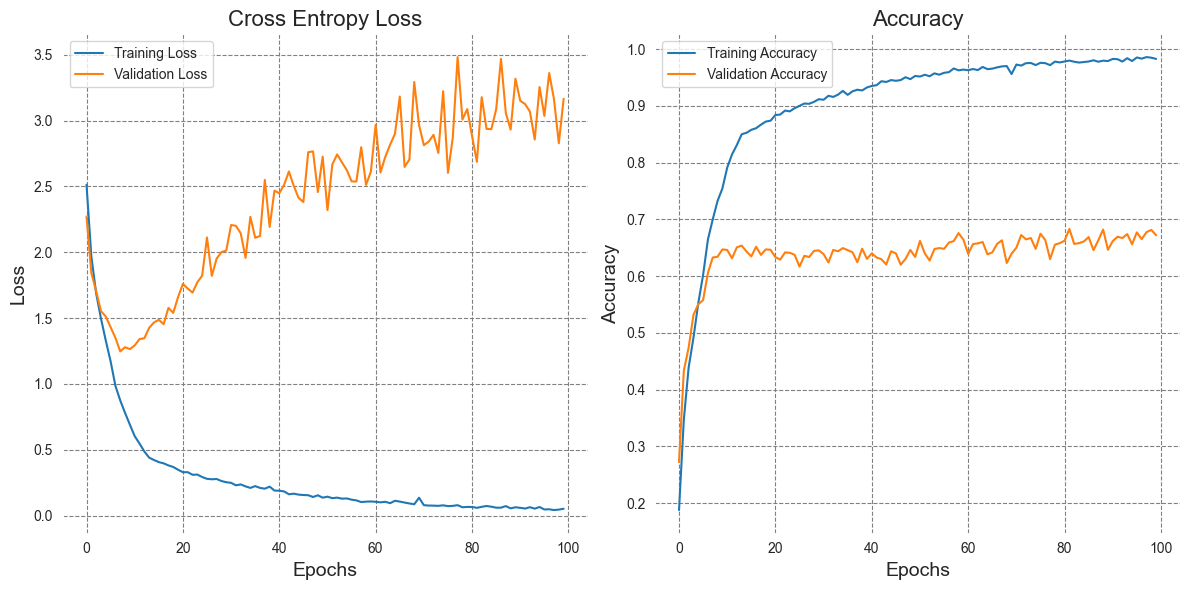

In [19]:
plot_lc(history)

<h5>Observation:</h5>

As we can see, there is definitely overfitting compared to the original results. The loss of the training model ends near 0.2 but the validation loss went above 4, which is much worse compared to our original model. Therefore, moving forward, we will be using the model with data augmentation. At the same time, this also proves my earlier point that data augmentation does help prevent overfitting as it allows the model to learn different prominent details of the vegetables from different versions of the photos. Next, we shall be using the learning rate scheduling.

#### 6b) LR Scheduling

In [36]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


epochs = 100
learning_rate = 1e-5
decay_rate = learning_rate / epochs
adam = Adam(lr = learning_rate, decay = decay_rate)

input_shape = (128, 128, 1)
num_classes = 15

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr= 0.001)

model.summary()
model.save("LRModel.h5")

# Train the model using fit_generator
history = model.fit_generator(
    datagen.flow(X_train, y_train, batch_size=64),
    steps_per_epoch=len(X_train) // 64,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[WandbCallback(save_model=True), reduce_lr]
)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 126, 126, 32)      320       
                                                                 
 activation_15 (Activation)  (None, 126, 126, 32)      0         
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 127008)            0         
                                                                 
 dense_18 (Dense)            (None, 128)               16257152  
                                                                 
 activation_16 (Activation)  (None, 128)               0         
                                                      

C:\Users\muhdf\AppData\Local\Temp\ipykernel_17668\2829414336.py:33: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


  5/141 [>.............................] - ETA: 5s - loss: 2.7158 - accuracy: 0.0625WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0169s vs `on_train_batch_end` time: 0.0199s). Check your callbacks.


141/141 [==============================] - 7s 46ms/step - loss: 2.6101 - accuracy: 0.1128 - val_loss: 2.6498 - val_accuracy: 0.1363 - lr: 1.0000e-05
Epoch 2/100
141/141 [==============================] - 7s 46ms/step - loss: 2.5222 - accuracy: 0.1598 - val_loss: 2.5743 - val_accuracy: 0.1717 - lr: 1.0000e-05
Epoch 3/100
141/141 [==============================] - 6s 45ms/step - loss: 2.4586 - accuracy: 0.1958 - val_loss: 2.5562 - val_accuracy: 0.1600 - lr: 1.0000e-05
Epoch 4/100
141/141 [==============================] - 7s 46ms/step - loss: 2.4195 - accuracy: 0.2058 - val_loss: 2.4996 - val_accuracy: 0.1543 - lr: 1.0000e-05
Epoch 5/100
141/141 [==============================] - 6s 44ms/step - loss: 2.3907 - accuracy: 0.2249 - val_loss: 2.5014 - val_accuracy: 0.1783 - lr: 1.0000e-05
Epoch 6/100
141/141 [==============================] - 7s 47ms/step - loss: 2.3506 - accuracy: 0.2392 - val_loss: 2.4434 - val_accuracy: 0.2113 - lr: 1.0000e-05
Epoch 7/100
141/141 [=========================

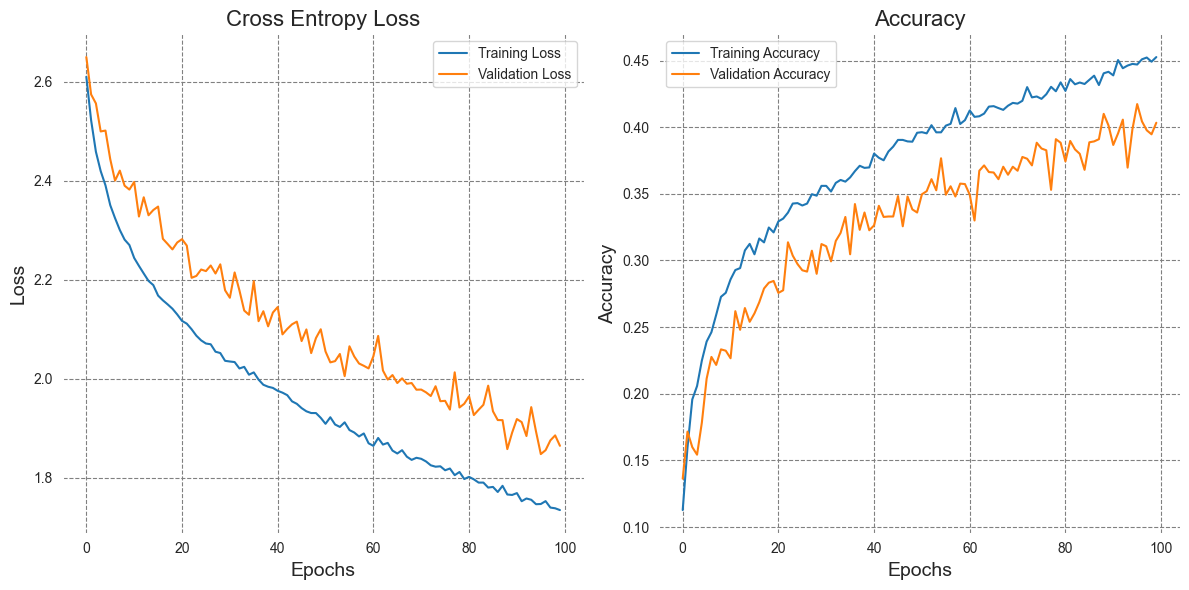

In [39]:
plot_lc(history)

In [48]:
print_training_history(history)

Training Loss: 1.7347296476364136
Validation Loss: 1.864540696144104
Training Accuracy: 0.45258814096450806
Validation Accuracy: 0.4033333361148834


<h5>Observations:</h5>
As we can see, it worsens the accuracy of the model as compared to the baseline model. However, we are not looking for the best accuracy in this case. It seems that LR scheduling works as a method to make the model more stable, which means that we can try to incorporate it in the final model.

#### 6c) Regularisation functions

To decide whether we use L1, L2, or elastic net, we first need to look at the reason we need to stabilise the data.

In [23]:
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation, Dense, Input, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l1_l2

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128))

model.add(Dropout(0.6))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(datagen.flow(X_train, y_train, batch_size=64),
                    epochs=100,
                    validation_data=(X_val, y_val),
                    callbacks=[WandbCallback(save_model=True)])

model.summary()

Epoch 1/100
  5/142 [>.............................] - ETA: 5s - loss: 18.7118 - accuracy: 0.0625WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0177s vs `on_train_batch_end` time: 0.0192s). Check your callbacks.


142/142 [==============================] - 7s 50ms/step - loss: 3.7190 - accuracy: 0.2377 - val_loss: 1.9634 - val_accuracy: 0.3843
Epoch 2/100
142/142 [==============================] - 6s 42ms/step - loss: 1.8999 - accuracy: 0.4015 - val_loss: 1.8484 - val_accuracy: 0.3983
Epoch 3/100
142/142 [==============================] - 6s 43ms/step - loss: 1.7391 - accuracy: 0.4531 - val_loss: 1.5664 - val_accuracy: 0.5087
Epoch 4/100
142/142 [==============================] - 6s 43ms/step - loss: 1.6155 - accuracy: 0.4977 - val_loss: 1.7800 - val_accuracy: 0.4143
Epoch 5/100
142/142 [==============================] - 6s 43ms/step - loss: 1.5633 - accuracy: 0.5056 - val_loss: 1.4742 - val_accuracy: 0.5387
Epoch 6/100
142/142 [==============================] - 6s 43ms/step - loss: 1.5042 - accuracy: 0.5264 - val_loss: 1.4333 - val_accuracy: 0.5590
Epoch 7/100
142/142 [==============================] - 6s 44ms/step - loss: 1.4561 - accuracy: 0.5412 - val_loss: 1.4735 - val_accuracy: 0.5223
Epoc

In [28]:
model.save("dropoutModel.h5")

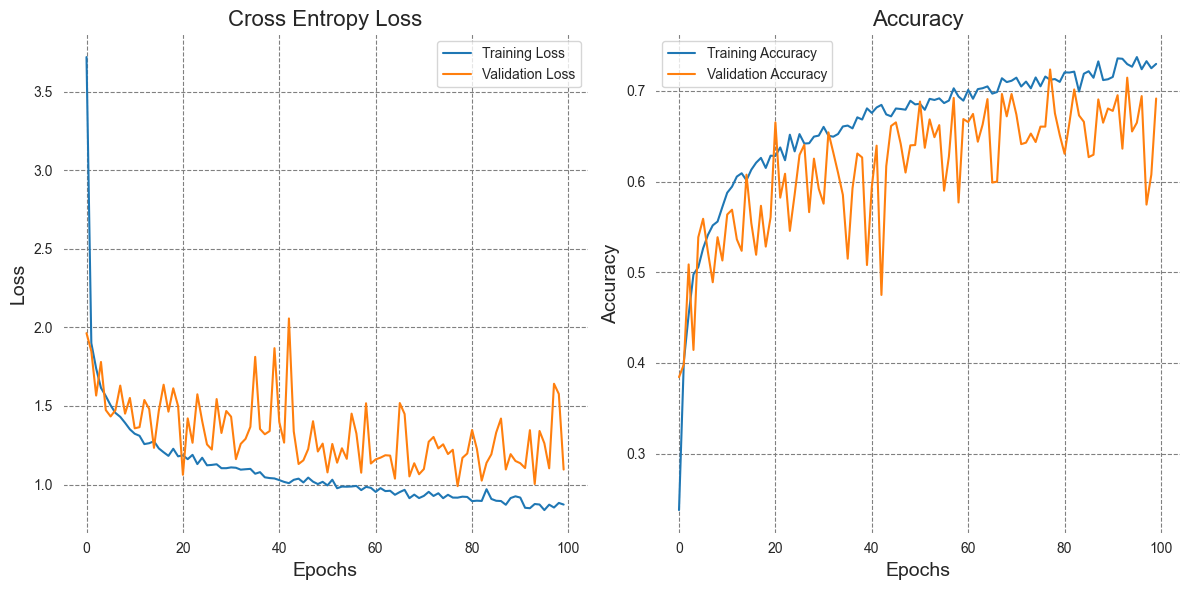

In [26]:
plot_lc(history)

In [30]:
from tensorflow.keras.models import load_model
dropoutModel = load_model("dropoutModel.h5")
print_acc_loss(dropoutModel, X_test, y_test)

Loss: 1.1351, Accuracy: 69.33%


#### 6d) Adding layers


In [14]:
import wandb
from wandb.keras import WandbCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Flatten, Dense

input_shape = (128, 128, 1)
 
# Create a sequential model
model = Sequential()

num_classes = 15
model.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add a second convolutional layer
model.add(Conv2D(64, kernel_size=(3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(datagen.flow(X_train, y_train, batch_size=64),
                    epochs=100,
                    validation_data=(X_val, y_val),
                    callbacks=[WandbCallback(save_model=True)])

model.summary()
model.save("2ConvModel.h5")


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/100
142/142 [==============================] - ETA: 0s - loss: 2.3898 - accuracy: 0.2237

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best)... Done. 0.2s


142/142 [==============================] - 19s 79ms/step - loss: 2.3898 - accuracy: 0.2237 - val_loss: 2.1758 - val_accuracy: 0.2987
Epoch 2/100
142/142 [==============================] - ETA: 0s - loss: 1.9795 - accuracy: 0.3583

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best)... Done. 0.2s


142/142 [==============================] - 10s 69ms/step - loss: 1.9795 - accuracy: 0.3583 - val_loss: 1.8818 - val_accuracy: 0.3907
Epoch 3/100
142/142 [==============================] - ETA: 0s - loss: 1.7723 - accuracy: 0.4266

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best)... Done. 0.2s


142/142 [==============================] - 9s 64ms/step - loss: 1.7723 - accuracy: 0.4266 - val_loss: 1.7662 - val_accuracy: 0.4473
Epoch 4/100
141/142 [============================>.] - ETA: 0s - loss: 1.5985 - accuracy: 0.4851

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best)... Done. 0.2s


142/142 [==============================] - 9s 63ms/step - loss: 1.5995 - accuracy: 0.4844 - val_loss: 1.6751 - val_accuracy: 0.4327
Epoch 5/100
141/142 [============================>.] - ETA: 0s - loss: 1.5155 - accuracy: 0.5071

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best)... Done. 0.2s


142/142 [==============================] - 10s 68ms/step - loss: 1.5148 - accuracy: 0.5071 - val_loss: 1.4544 - val_accuracy: 0.5177
Epoch 6/100
142/142 [==============================] - 7s 52ms/step - loss: 1.3956 - accuracy: 0.5496 - val_loss: 1.8612 - val_accuracy: 0.4083
Epoch 7/100
141/142 [============================>.] - ETA: 0s - loss: 1.3423 - accuracy: 0.5649

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best)... Done. 0.2s


142/142 [==============================] - 9s 65ms/step - loss: 1.3407 - accuracy: 0.5659 - val_loss: 1.4057 - val_accuracy: 0.5220
Epoch 8/100
141/142 [============================>.] - ETA: 0s - loss: 1.2754 - accuracy: 0.5849

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best)... Done. 0.2s


142/142 [==============================] - 9s 60ms/step - loss: 1.2750 - accuracy: 0.5843 - val_loss: 1.2765 - val_accuracy: 0.5853
Epoch 9/100
142/142 [==============================] - 7s 47ms/step - loss: 1.2565 - accuracy: 0.5901 - val_loss: 1.4203 - val_accuracy: 0.5373
Epoch 10/100
142/142 [==============================] - 7s 46ms/step - loss: 1.1975 - accuracy: 0.6061 - val_loss: 1.5759 - val_accuracy: 0.4957
Epoch 11/100
142/142 [==============================] - ETA: 0s - loss: 1.1463 - accuracy: 0.6216

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best)... Done. 0.2s


142/142 [==============================] - 9s 64ms/step - loss: 1.1463 - accuracy: 0.6216 - val_loss: 1.0427 - val_accuracy: 0.6503
Epoch 12/100
142/142 [==============================] - 8s 53ms/step - loss: 1.1134 - accuracy: 0.6335 - val_loss: 1.1818 - val_accuracy: 0.6093
Epoch 13/100
142/142 [==============================] - 7s 49ms/step - loss: 1.0826 - accuracy: 0.6453 - val_loss: 1.2719 - val_accuracy: 0.5870
Epoch 14/100
141/142 [============================>.] - ETA: 0s - loss: 1.0628 - accuracy: 0.6506

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best)... Done. 0.2s


142/142 [==============================] - 8s 59ms/step - loss: 1.0624 - accuracy: 0.6502 - val_loss: 1.0034 - val_accuracy: 0.6727
Epoch 15/100
142/142 [==============================] - 7s 48ms/step - loss: 1.0448 - accuracy: 0.6511 - val_loss: 1.1570 - val_accuracy: 0.6133
Epoch 16/100
141/142 [============================>.] - ETA: 0s - loss: 0.9852 - accuracy: 0.6740

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best)... Done. 0.2s


142/142 [==============================] - 9s 64ms/step - loss: 0.9854 - accuracy: 0.6741 - val_loss: 0.9081 - val_accuracy: 0.7077
Epoch 17/100
142/142 [==============================] - 7s 50ms/step - loss: 0.9890 - accuracy: 0.6808 - val_loss: 1.2838 - val_accuracy: 0.6057
Epoch 18/100
141/142 [============================>.] - ETA: 0s - loss: 0.9714 - accuracy: 0.6825

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best)... Done. 0.2s


142/142 [==============================] - 9s 62ms/step - loss: 0.9740 - accuracy: 0.6815 - val_loss: 0.9031 - val_accuracy: 0.7047
Epoch 19/100
142/142 [==============================] - 7s 51ms/step - loss: 0.9595 - accuracy: 0.6827 - val_loss: 0.9347 - val_accuracy: 0.6900
Epoch 20/100
142/142 [==============================] - 7s 47ms/step - loss: 0.9069 - accuracy: 0.6987 - val_loss: 0.9995 - val_accuracy: 0.6853
Epoch 21/100
142/142 [==============================] - 6s 45ms/step - loss: 0.9517 - accuracy: 0.6905 - val_loss: 1.2902 - val_accuracy: 0.5947
Epoch 22/100
142/142 [==============================] - 6s 44ms/step - loss: 0.8990 - accuracy: 0.7053 - val_loss: 0.9294 - val_accuracy: 0.7020
Epoch 23/100
142/142 [==============================] - 6s 45ms/step - loss: 0.8499 - accuracy: 0.7172 - val_loss: 1.1892 - val_accuracy: 0.6327
Epoch 24/100
141/142 [============================>.] - ETA: 0s - loss: 0.8660 - accuracy: 0.7116

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best)... Done. 0.2s


142/142 [==============================] - 8s 56ms/step - loss: 0.8644 - accuracy: 0.7126 - val_loss: 0.8009 - val_accuracy: 0.7417
Epoch 25/100
142/142 [==============================] - 7s 46ms/step - loss: 0.8503 - accuracy: 0.7201 - val_loss: 0.8261 - val_accuracy: 0.7327
Epoch 26/100
142/142 [==============================] - 7s 47ms/step - loss: 0.8345 - accuracy: 0.7235 - val_loss: 1.2937 - val_accuracy: 0.6097
Epoch 27/100
142/142 [==============================] - ETA: 0s - loss: 0.8058 - accuracy: 0.7360

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best)... Done. 0.2s


142/142 [==============================] - 8s 58ms/step - loss: 0.8058 - accuracy: 0.7360 - val_loss: 0.7980 - val_accuracy: 0.7460
Epoch 28/100
142/142 [==============================] - 7s 47ms/step - loss: 0.7977 - accuracy: 0.7370 - val_loss: 0.8872 - val_accuracy: 0.7173
Epoch 29/100
142/142 [==============================] - 6s 45ms/step - loss: 0.7913 - accuracy: 0.7346 - val_loss: 0.8313 - val_accuracy: 0.7413
Epoch 30/100
141/142 [============================>.] - ETA: 0s - loss: 0.7871 - accuracy: 0.7409

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best)... Done. 0.2s


142/142 [==============================] - 8s 59ms/step - loss: 0.7875 - accuracy: 0.7404 - val_loss: 0.7584 - val_accuracy: 0.7637
Epoch 31/100
141/142 [============================>.] - ETA: 0s - loss: 0.7782 - accuracy: 0.7422

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best)... Done. 0.2s


142/142 [==============================] - 9s 62ms/step - loss: 0.7781 - accuracy: 0.7419 - val_loss: 0.6758 - val_accuracy: 0.7877
Epoch 32/100
142/142 [==============================] - 7s 47ms/step - loss: 0.7486 - accuracy: 0.7489 - val_loss: 1.1191 - val_accuracy: 0.6643
Epoch 33/100
142/142 [==============================] - 6s 43ms/step - loss: 0.7706 - accuracy: 0.7428 - val_loss: 0.8525 - val_accuracy: 0.7283
Epoch 34/100
142/142 [==============================] - 6s 44ms/step - loss: 0.7335 - accuracy: 0.7571 - val_loss: 0.7705 - val_accuracy: 0.7567
Epoch 35/100
142/142 [==============================] - 6s 45ms/step - loss: 0.7234 - accuracy: 0.7616 - val_loss: 0.9798 - val_accuracy: 0.6960
Epoch 36/100
142/142 [==============================] - 7s 46ms/step - loss: 0.7214 - accuracy: 0.7627 - val_loss: 0.7106 - val_accuracy: 0.7763
Epoch 37/100
141/142 [============================>.] - ETA: 0s - loss: 0.7226 - accuracy: 0.7603

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best)... Done. 0.2s


142/142 [==============================] - 8s 59ms/step - loss: 0.7225 - accuracy: 0.7602 - val_loss: 0.6247 - val_accuracy: 0.8063
Epoch 38/100
142/142 [==============================] - ETA: 0s - loss: 0.6999 - accuracy: 0.7661

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best)... Done. 0.2s


142/142 [==============================] - 8s 53ms/step - loss: 0.6999 - accuracy: 0.7661 - val_loss: 0.5809 - val_accuracy: 0.8217
Epoch 39/100
142/142 [==============================] - 6s 43ms/step - loss: 0.6905 - accuracy: 0.7685 - val_loss: 1.0384 - val_accuracy: 0.6780
Epoch 40/100
141/142 [============================>.] - ETA: 0s - loss: 0.6960 - accuracy: 0.7707

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best)... Done. 0.2s


142/142 [==============================] - 7s 52ms/step - loss: 0.6953 - accuracy: 0.7713 - val_loss: 0.5320 - val_accuracy: 0.8417
Epoch 41/100
141/142 [============================>.] - ETA: 0s - loss: 0.6907 - accuracy: 0.7694

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best)... Done. 0.2s


142/142 [==============================] - 8s 55ms/step - loss: 0.6905 - accuracy: 0.7694 - val_loss: 0.5238 - val_accuracy: 0.8387
Epoch 42/100
142/142 [==============================] - 7s 51ms/step - loss: 0.6497 - accuracy: 0.7829 - val_loss: 0.7211 - val_accuracy: 0.7680
Epoch 43/100
142/142 [==============================] - ETA: 0s - loss: 0.6633 - accuracy: 0.7735

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best)... Done. 0.2s


142/142 [==============================] - 9s 64ms/step - loss: 0.6633 - accuracy: 0.7735 - val_loss: 0.5115 - val_accuracy: 0.8387
Epoch 44/100
142/142 [==============================] - 7s 50ms/step - loss: 0.6813 - accuracy: 0.7730 - val_loss: 1.2794 - val_accuracy: 0.6220
Epoch 45/100
142/142 [==============================] - 7s 46ms/step - loss: 0.6599 - accuracy: 0.7795 - val_loss: 0.6717 - val_accuracy: 0.7910
Epoch 46/100
142/142 [==============================] - 6s 45ms/step - loss: 0.6533 - accuracy: 0.7859 - val_loss: 0.7506 - val_accuracy: 0.7727
Epoch 47/100
142/142 [==============================] - 6s 43ms/step - loss: 0.6442 - accuracy: 0.7859 - val_loss: 0.6375 - val_accuracy: 0.7977
Epoch 48/100
142/142 [==============================] - 7s 48ms/step - loss: 0.6440 - accuracy: 0.7857 - val_loss: 0.5952 - val_accuracy: 0.8237
Epoch 49/100
142/142 [==============================] - 7s 46ms/step - loss: 0.6610 - accuracy: 0.7745 - val_loss: 0.7404 - val_accuracy: 0.770

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best)... Done. 0.2s


142/142 [==============================] - 8s 58ms/step - loss: 0.6150 - accuracy: 0.7961 - val_loss: 0.4330 - val_accuracy: 0.8677
Epoch 60/100
142/142 [==============================] - 7s 46ms/step - loss: 0.5635 - accuracy: 0.8115 - val_loss: 0.4846 - val_accuracy: 0.8510
Epoch 61/100
142/142 [==============================] - 7s 46ms/step - loss: 0.5683 - accuracy: 0.8054 - val_loss: 0.6252 - val_accuracy: 0.8047
Epoch 62/100
142/142 [==============================] - 7s 46ms/step - loss: 0.5568 - accuracy: 0.8098 - val_loss: 0.7076 - val_accuracy: 0.7887
Epoch 63/100
142/142 [==============================] - 6s 45ms/step - loss: 0.5778 - accuracy: 0.8036 - val_loss: 0.6798 - val_accuracy: 0.7850
Epoch 64/100
142/142 [==============================] - 7s 46ms/step - loss: 0.5397 - accuracy: 0.8217 - val_loss: 0.7145 - val_accuracy: 0.7853
Epoch 65/100
142/142 [==============================] - 6s 45ms/step - loss: 0.5478 - accuracy: 0.8167 - val_loss: 0.6189 - val_accuracy: 0.814

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231125_184703-fr5z9hlx\files\model-best)... Done. 0.2s


142/142 [==============================] - 8s 56ms/step - loss: 0.4562 - accuracy: 0.8454 - val_loss: 0.4097 - val_accuracy: 0.8777
Epoch 88/100
142/142 [==============================] - 7s 46ms/step - loss: 0.4545 - accuracy: 0.8478 - val_loss: 0.6183 - val_accuracy: 0.8147
Epoch 89/100
142/142 [==============================] - 6s 44ms/step - loss: 0.4671 - accuracy: 0.8391 - val_loss: 0.4807 - val_accuracy: 0.8573
Epoch 90/100
142/142 [==============================] - 6s 45ms/step - loss: 0.4458 - accuracy: 0.8470 - val_loss: 0.6760 - val_accuracy: 0.8003
Epoch 91/100
142/142 [==============================] - 6s 44ms/step - loss: 0.4505 - accuracy: 0.8492 - val_loss: 0.5578 - val_accuracy: 0.8340
Epoch 92/100
142/142 [==============================] - 6s 45ms/step - loss: 0.4980 - accuracy: 0.8299 - val_loss: 0.8152 - val_accuracy: 0.7603
Epoch 93/100
142/142 [==============================] - 6s 44ms/step - loss: 0.4635 - accuracy: 0.8443 - val_loss: 0.6781 - val_accuracy: 0.800

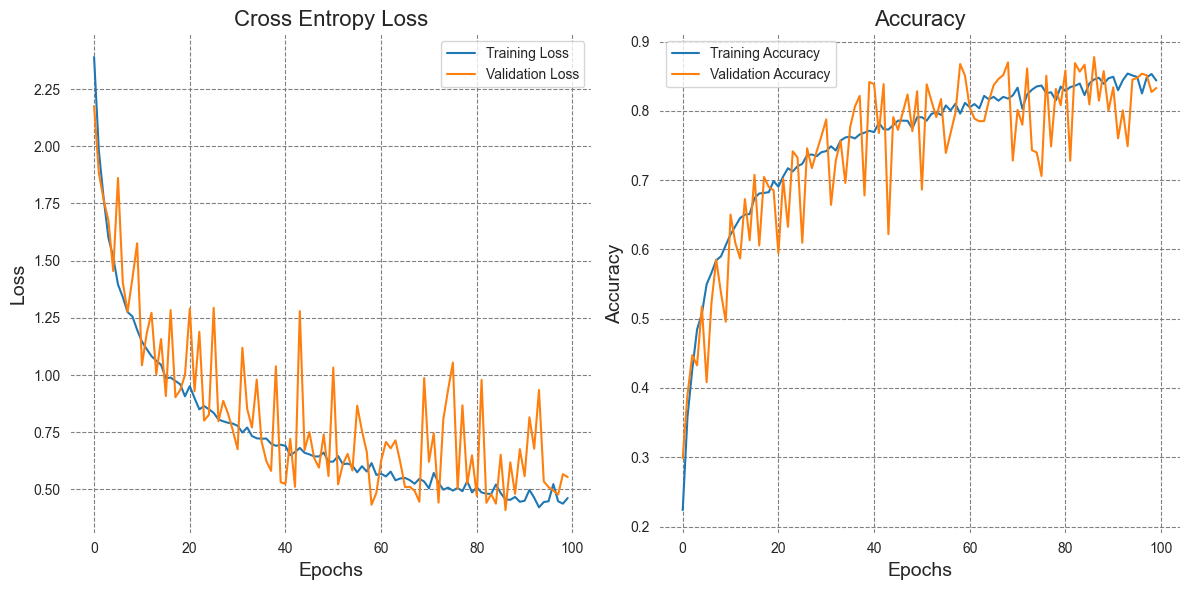

In [15]:
plot_lc(history)

In [25]:
from tensorflow.keras.models import load_model
twoLayer = load_model("2ConvModel.h5")
print_loss_acc(twoLayer, X_test, y_test)

Loss: 0.6079132556915283
Accuracy: 0.8273333311080933


3 Layers

In [18]:
input_shape = (128, 128, 1)
 
# Create a sequential model
model = Sequential()

num_classes = 15
model.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add a second convolutional layer
model.add(Conv2D(64, kernel_size=(3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.save("3ConvModel.h5")
history = model.fit(datagen.flow(X_train, y_train, batch_size=64),
                    epochs=100,
                    validation_data=(X_val, y_val),
                    callbacks=[WandbCallback(save_model=True)])

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/100
142/142 [==============================] - ETA: 0s - loss: 2.4175 - accuracy: 0.1984

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best)... Done. 0.1s


142/142 [==============================] - 14s 78ms/step - loss: 2.4175 - accuracy: 0.1984 - val_loss: 2.3880 - val_accuracy: 0.2657
Epoch 2/100
142/142 [==============================] - ETA: 0s - loss: 1.9952 - accuracy: 0.3505

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best)... Done. 0.1s


142/142 [==============================] - 9s 63ms/step - loss: 1.9952 - accuracy: 0.3505 - val_loss: 1.8562 - val_accuracy: 0.3837
Epoch 3/100
142/142 [==============================] - ETA: 0s - loss: 1.7202 - accuracy: 0.4465

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best)... Done. 0.1s


142/142 [==============================] - 9s 64ms/step - loss: 1.7202 - accuracy: 0.4465 - val_loss: 1.6269 - val_accuracy: 0.4710
Epoch 4/100
142/142 [==============================] - 8s 56ms/step - loss: 1.5367 - accuracy: 0.5052 - val_loss: 1.9033 - val_accuracy: 0.4077
Epoch 5/100
142/142 [==============================] - 8s 58ms/step - loss: 1.4144 - accuracy: 0.5404 - val_loss: 1.6485 - val_accuracy: 0.4727
Epoch 6/100
142/142 [==============================] - ETA: 0s - loss: 1.2560 - accuracy: 0.5939

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best)... Done. 0.1s


142/142 [==============================] - 9s 61ms/step - loss: 1.2560 - accuracy: 0.5939 - val_loss: 1.1006 - val_accuracy: 0.6413
Epoch 7/100
142/142 [==============================] - 7s 52ms/step - loss: 1.1879 - accuracy: 0.6142 - val_loss: 1.2695 - val_accuracy: 0.5840
Epoch 8/100
142/142 [==============================] - 7s 50ms/step - loss: 1.1119 - accuracy: 0.6376 - val_loss: 1.3167 - val_accuracy: 0.5673
Epoch 9/100
142/142 [==============================] - 7s 50ms/step - loss: 1.0377 - accuracy: 0.6643 - val_loss: 1.1612 - val_accuracy: 0.6200
Epoch 10/100
142/142 [==============================] - ETA: 0s - loss: 0.9921 - accuracy: 0.6827

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best)... Done. 0.1s


142/142 [==============================] - 9s 61ms/step - loss: 0.9921 - accuracy: 0.6827 - val_loss: 1.0595 - val_accuracy: 0.6563
Epoch 11/100
141/142 [============================>.] - ETA: 0s - loss: 0.9026 - accuracy: 0.7053

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best)... Done. 0.1s


142/142 [==============================] - 9s 63ms/step - loss: 0.9024 - accuracy: 0.7055 - val_loss: 0.8092 - val_accuracy: 0.7417
Epoch 12/100
142/142 [==============================] - 7s 51ms/step - loss: 0.8906 - accuracy: 0.7090 - val_loss: 0.9143 - val_accuracy: 0.7117
Epoch 13/100
142/142 [==============================] - 7s 50ms/step - loss: 0.8452 - accuracy: 0.7237 - val_loss: 1.8712 - val_accuracy: 0.5033
Epoch 14/100
142/142 [==============================] - 7s 49ms/step - loss: 0.8207 - accuracy: 0.7333 - val_loss: 0.9093 - val_accuracy: 0.7153
Epoch 15/100
142/142 [==============================] - 7s 49ms/step - loss: 0.7693 - accuracy: 0.7520 - val_loss: 0.9850 - val_accuracy: 0.6900
Epoch 16/100
142/142 [==============================] - ETA: 0s - loss: 0.7334 - accuracy: 0.7599

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best)... Done. 0.1s


142/142 [==============================] - 9s 60ms/step - loss: 0.7334 - accuracy: 0.7599 - val_loss: 0.6806 - val_accuracy: 0.7857
Epoch 17/100
142/142 [==============================] - 7s 51ms/step - loss: 0.7030 - accuracy: 0.7730 - val_loss: 1.0803 - val_accuracy: 0.6753
Epoch 18/100
142/142 [==============================] - 7s 50ms/step - loss: 0.6529 - accuracy: 0.7846 - val_loss: 0.7061 - val_accuracy: 0.7840
Epoch 19/100
142/142 [==============================] - 7s 50ms/step - loss: 0.6699 - accuracy: 0.7849 - val_loss: 0.7676 - val_accuracy: 0.7603
Epoch 20/100
141/142 [============================>.] - ETA: 0s - loss: 0.6756 - accuracy: 0.7812

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best)... Done. 0.1s


142/142 [==============================] - 9s 62ms/step - loss: 0.6786 - accuracy: 0.7800 - val_loss: 0.5848 - val_accuracy: 0.8110
Epoch 21/100
142/142 [==============================] - 7s 51ms/step - loss: 0.6586 - accuracy: 0.7871 - val_loss: 1.1322 - val_accuracy: 0.6693
Epoch 22/100
142/142 [==============================] - 7s 49ms/step - loss: 0.6136 - accuracy: 0.7977 - val_loss: 0.6360 - val_accuracy: 0.8010
Epoch 23/100
142/142 [==============================] - 7s 49ms/step - loss: 0.5952 - accuracy: 0.8045 - val_loss: 0.7010 - val_accuracy: 0.7887
Epoch 24/100
141/142 [============================>.] - ETA: 0s - loss: 0.5816 - accuracy: 0.8078

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best)... Done. 0.1s


142/142 [==============================] - 9s 63ms/step - loss: 0.5820 - accuracy: 0.8078 - val_loss: 0.5561 - val_accuracy: 0.8290
Epoch 25/100
141/142 [============================>.] - ETA: 0s - loss: 0.6119 - accuracy: 0.8038

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best)... Done. 0.1s


142/142 [==============================] - 9s 63ms/step - loss: 0.6119 - accuracy: 0.8038 - val_loss: 0.4533 - val_accuracy: 0.8677
Epoch 26/100
142/142 [==============================] - 7s 51ms/step - loss: 0.5138 - accuracy: 0.8241 - val_loss: 0.5679 - val_accuracy: 0.8267
Epoch 27/100
142/142 [==============================] - 7s 50ms/step - loss: 0.5247 - accuracy: 0.8248 - val_loss: 0.5991 - val_accuracy: 0.8140
Epoch 28/100
142/142 [==============================] - 7s 50ms/step - loss: 0.5174 - accuracy: 0.8296 - val_loss: 0.5980 - val_accuracy: 0.8117
Epoch 29/100
141/142 [============================>.] - ETA: 0s - loss: 0.5616 - accuracy: 0.8154

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best)... Done. 0.1s


142/142 [==============================] - 8s 59ms/step - loss: 0.5625 - accuracy: 0.8156 - val_loss: 0.4465 - val_accuracy: 0.8607
Epoch 30/100
142/142 [==============================] - 7s 51ms/step - loss: 0.4856 - accuracy: 0.8473 - val_loss: 0.6308 - val_accuracy: 0.8123
Epoch 31/100
141/142 [============================>.] - ETA: 0s - loss: 0.5083 - accuracy: 0.8322

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best)... Done. 0.1s


142/142 [==============================] - 9s 60ms/step - loss: 0.5078 - accuracy: 0.8324 - val_loss: 0.4456 - val_accuracy: 0.8640
Epoch 32/100
142/142 [==============================] - 7s 51ms/step - loss: 0.4660 - accuracy: 0.8450 - val_loss: 0.6313 - val_accuracy: 0.8097
Epoch 33/100
142/142 [==============================] - 7s 50ms/step - loss: 0.4345 - accuracy: 0.8537 - val_loss: 0.5445 - val_accuracy: 0.8340
Epoch 34/100
141/142 [============================>.] - ETA: 0s - loss: 0.4372 - accuracy: 0.8589

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best)... Done. 0.1s


142/142 [==============================] - 9s 61ms/step - loss: 0.4369 - accuracy: 0.8591 - val_loss: 0.4070 - val_accuracy: 0.8767
Epoch 35/100
142/142 [==============================] - 7s 50ms/step - loss: 0.4240 - accuracy: 0.8612 - val_loss: 0.5389 - val_accuracy: 0.8353
Epoch 36/100
142/142 [==============================] - 7s 50ms/step - loss: 0.4112 - accuracy: 0.8687 - val_loss: 0.7731 - val_accuracy: 0.7847
Epoch 37/100
142/142 [==============================] - 7s 49ms/step - loss: 0.4286 - accuracy: 0.8604 - val_loss: 0.4378 - val_accuracy: 0.8693
Epoch 38/100
141/142 [============================>.] - ETA: 0s - loss: 0.4004 - accuracy: 0.8671

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best)... Done. 0.1s


142/142 [==============================] - 9s 60ms/step - loss: 0.3995 - accuracy: 0.8672 - val_loss: 0.3207 - val_accuracy: 0.9047
Epoch 39/100
142/142 [==============================] - 7s 51ms/step - loss: 0.4173 - accuracy: 0.8610 - val_loss: 0.3892 - val_accuracy: 0.8857
Epoch 40/100
141/142 [============================>.] - ETA: 0s - loss: 0.3828 - accuracy: 0.8723

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best)... Done. 0.1s


142/142 [==============================] - 9s 61ms/step - loss: 0.3830 - accuracy: 0.8721 - val_loss: 0.2882 - val_accuracy: 0.9107
Epoch 41/100
142/142 [==============================] - 7s 51ms/step - loss: 0.3680 - accuracy: 0.8797 - val_loss: 0.6286 - val_accuracy: 0.8153
Epoch 42/100
142/142 [==============================] - 7s 50ms/step - loss: 0.4279 - accuracy: 0.8610 - val_loss: 0.3731 - val_accuracy: 0.8890
Epoch 43/100
142/142 [==============================] - 7s 49ms/step - loss: 0.3863 - accuracy: 0.8711 - val_loss: 0.4590 - val_accuracy: 0.8677
Epoch 44/100
142/142 [==============================] - 7s 49ms/step - loss: 0.4041 - accuracy: 0.8673 - val_loss: 0.3918 - val_accuracy: 0.8720
Epoch 45/100
142/142 [==============================] - 7s 50ms/step - loss: 0.3633 - accuracy: 0.8778 - val_loss: 0.4415 - val_accuracy: 0.8673
Epoch 46/100
142/142 [==============================] - 7s 50ms/step - loss: 0.3587 - accuracy: 0.8797 - val_loss: 0.4901 - val_accuracy: 0.861

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best)... Done. 0.1s


142/142 [==============================] - 9s 60ms/step - loss: 0.3506 - accuracy: 0.8856 - val_loss: 0.2774 - val_accuracy: 0.9253
Epoch 56/100
142/142 [==============================] - 7s 48ms/step - loss: 0.2924 - accuracy: 0.9019 - val_loss: 0.4369 - val_accuracy: 0.8793
Epoch 57/100
142/142 [==============================] - 7s 47ms/step - loss: 0.2982 - accuracy: 0.9024 - val_loss: 0.3712 - val_accuracy: 0.8890
Epoch 58/100
142/142 [==============================] - 7s 47ms/step - loss: 0.2827 - accuracy: 0.9055 - val_loss: 0.4295 - val_accuracy: 0.8813
Epoch 59/100
142/142 [==============================] - 7s 47ms/step - loss: 0.2956 - accuracy: 0.9039 - val_loss: 0.5796 - val_accuracy: 0.8447
Epoch 60/100
142/142 [==============================] - 7s 46ms/step - loss: 0.2864 - accuracy: 0.9040 - val_loss: 0.4483 - val_accuracy: 0.8737
Epoch 61/100
142/142 [==============================] - 7s 47ms/step - loss: 0.3259 - accuracy: 0.8936 - val_loss: 0.4314 - val_accuracy: 0.873

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best)... Done. 0.1s


142/142 [==============================] - 8s 55ms/step - loss: 0.3068 - accuracy: 0.8969 - val_loss: 0.2612 - val_accuracy: 0.9190
Epoch 63/100
142/142 [==============================] - 7s 46ms/step - loss: 0.2886 - accuracy: 0.9039 - val_loss: 0.3462 - val_accuracy: 0.8990
Epoch 64/100
142/142 [==============================] - 7s 46ms/step - loss: 0.2817 - accuracy: 0.9062 - val_loss: 0.7912 - val_accuracy: 0.7877
Epoch 65/100
142/142 [==============================] - 6s 45ms/step - loss: 0.2816 - accuracy: 0.9073 - val_loss: 0.3054 - val_accuracy: 0.9137
Epoch 66/100
142/142 [==============================] - 6s 45ms/step - loss: 0.2599 - accuracy: 0.9107 - val_loss: 0.3222 - val_accuracy: 0.9023
Epoch 67/100
142/142 [==============================] - 6s 45ms/step - loss: 0.2557 - accuracy: 0.9153 - val_loss: 0.4505 - val_accuracy: 0.8687
Epoch 68/100
142/142 [==============================] - 6s 45ms/step - loss: 0.2745 - accuracy: 0.9070 - val_loss: 0.3711 - val_accuracy: 0.892

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best)... Done. 0.1s


142/142 [==============================] - 8s 56ms/step - loss: 0.2510 - accuracy: 0.9174 - val_loss: 0.2383 - val_accuracy: 0.9293
Epoch 75/100
142/142 [==============================] - 6s 45ms/step - loss: 0.2586 - accuracy: 0.9142 - val_loss: 0.4435 - val_accuracy: 0.8767
Epoch 76/100
142/142 [==============================] - ETA: 0s - loss: 0.2444 - accuracy: 0.9170

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best)... Done. 0.1s


142/142 [==============================] - 8s 55ms/step - loss: 0.2444 - accuracy: 0.9170 - val_loss: 0.2358 - val_accuracy: 0.9303
Epoch 77/100
142/142 [==============================] - 6s 45ms/step - loss: 0.2454 - accuracy: 0.9166 - val_loss: 0.3211 - val_accuracy: 0.9153
Epoch 78/100
142/142 [==============================] - 6s 45ms/step - loss: 0.2706 - accuracy: 0.9066 - val_loss: 0.4346 - val_accuracy: 0.8837
Epoch 79/100
142/142 [==============================] - 6s 45ms/step - loss: 0.2419 - accuracy: 0.9176 - val_loss: 0.4054 - val_accuracy: 0.8907
Epoch 80/100
142/142 [==============================] - 6s 45ms/step - loss: 0.2426 - accuracy: 0.9224 - val_loss: 0.4101 - val_accuracy: 0.8860
Epoch 81/100
142/142 [==============================] - 6s 45ms/step - loss: 0.2395 - accuracy: 0.9212 - val_loss: 0.3668 - val_accuracy: 0.8990
Epoch 82/100
142/142 [==============================] - 6s 45ms/step - loss: 0.2467 - accuracy: 0.9168 - val_loss: 0.2673 - val_accuracy: 0.922

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best)... Done. 0.1s


142/142 [==============================] - 8s 56ms/step - loss: 0.2260 - accuracy: 0.9222 - val_loss: 0.2147 - val_accuracy: 0.9367
Epoch 87/100
142/142 [==============================] - 7s 48ms/step - loss: 0.2419 - accuracy: 0.9187 - val_loss: 0.2533 - val_accuracy: 0.9297
Epoch 88/100
141/142 [============================>.] - ETA: 0s - loss: 0.2547 - accuracy: 0.9150

INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\muhdf\OneDrive\Documents\GitHub\poly\Deep Learning\CA1\CNN\wandb\run-20231126_130847-1ne8fq5w\files\model-best)... Done. 0.1s


142/142 [==============================] - 8s 57ms/step - loss: 0.2547 - accuracy: 0.9148 - val_loss: 0.2037 - val_accuracy: 0.9363
Epoch 89/100
142/142 [==============================] - 7s 48ms/step - loss: 0.2170 - accuracy: 0.9286 - val_loss: 0.4113 - val_accuracy: 0.8893
Epoch 90/100
142/142 [==============================] - 7s 47ms/step - loss: 0.2174 - accuracy: 0.9292 - val_loss: 0.3218 - val_accuracy: 0.9047
Epoch 91/100
142/142 [==============================] - 7s 47ms/step - loss: 0.2271 - accuracy: 0.9245 - val_loss: 0.3194 - val_accuracy: 0.9120
Epoch 92/100
142/142 [==============================] - 7s 47ms/step - loss: 0.2097 - accuracy: 0.9301 - val_loss: 0.4270 - val_accuracy: 0.8923
Epoch 93/100
142/142 [==============================] - 7s 47ms/step - loss: 0.2144 - accuracy: 0.9280 - val_loss: 0.3934 - val_accuracy: 0.8987
Epoch 94/100
142/142 [==============================] - 7s 47ms/step - loss: 0.2097 - accuracy: 0.9312 - val_loss: 0.3750 - val_accuracy: 0.899

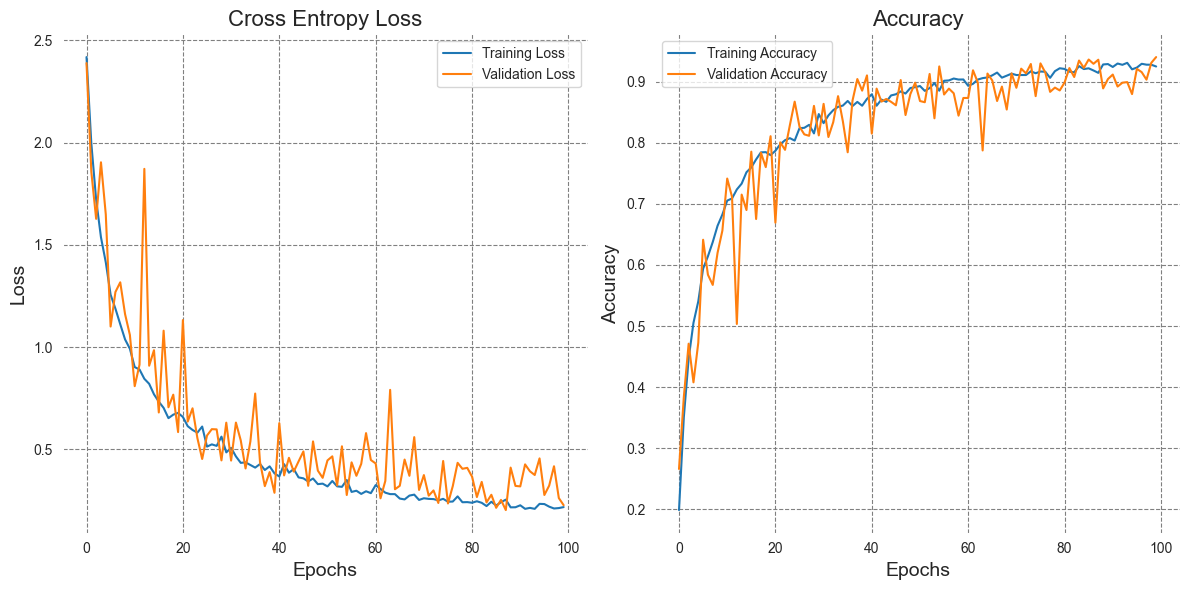

In [24]:
plot_lc(history)

In [27]:
threeLayer = load_model("3ConvModel.h5")
loss, accuracy = threeLayer.evaluate(X_test, y_test)

final_train_loss = history.history['loss'][-1]
final_train_accuracy = history.history['accuracy'][-1]
    
final_val_loss = history.history['val_loss'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

print(f'Final Training Loss: {final_train_loss:.4f}')
print(f'Final Training Accuracy: {final_train_accuracy:.4f}')

print(f'Final Validation Loss: {final_val_loss:.4f}')
print(f'Final Validation Accuracy: {final_val_accuracy:.4f}')

94/94 [==============================] - 1s 7ms/step - loss: 2.7109 - accuracy: 0.0633
Final Training Loss: 0.2182
Final Training Accuracy: 0.9252
Final Validation Loss: 0.2275
Final Validation Accuracy: 0.9407


Final model:

In [21]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

epochs = 100
learning_rate = 1e-3
decay_rate = learning_rate / epochs
# adam = Adam(lr = learning_rate, decay = decay_rate)
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate, decay_steps = 100000, decay_rate = decay_rate)
optimizer = Adam(learning_rate = lr_schedule)

input_shape = (128, 128, 1)
num_classes = 15

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr= 0.01)

model.summary()
model.save("finalModel.h5", save_format = "tf")
model.save_weights("finalModel_weights.h5")

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    steps_per_epoch=len(X_train) // 64,
    epochs=100,
    validation_data=(X_val, y_val),
    # callbacks=[WandbCallback(save_model=True), reduce_lr]
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      320       
                                                                 
 activation_4 (Activation)   (None, 126, 126, 32)      0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 activation_5 (Activation)   (None, 61, 61, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                 

141/141 [==============================] - 38s 259ms/step - loss: 2.3156 - accuracy: 0.2356 - val_loss: 2.0417 - val_accuracy: 0.3427
Epoch 2/100
141/141 [==============================] - 36s 255ms/step - loss: 1.8994 - accuracy: 0.3812 - val_loss: 1.9953 - val_accuracy: 0.3477
Epoch 3/100
141/141 [==============================] - 36s 255ms/step - loss: 1.6065 - accuracy: 0.4785 - val_loss: 1.3575 - val_accuracy: 0.5573
Epoch 4/100
141/141 [==============================] - 37s 261ms/step - loss: 1.4407 - accuracy: 0.5290 - val_loss: 1.2671 - val_accuracy: 0.5873
Epoch 5/100
141/141 [==============================] - 39s 277ms/step - loss: 1.3197 - accuracy: 0.5720 - val_loss: 1.3198 - val_accuracy: 0.5507
Epoch 6/100
141/141 [==============================] - 37s 263ms/step - loss: 1.1465 - accuracy: 0.6213 - val_loss: 0.9884 - val_accuracy: 0.6690
Epoch 7/100
141/141 [==============================] - 37s 264ms/step - loss: 1.0917 - accuracy: 0.6475 - val_loss: 1.0934 - val_accurac

KeyboardInterrupt: 

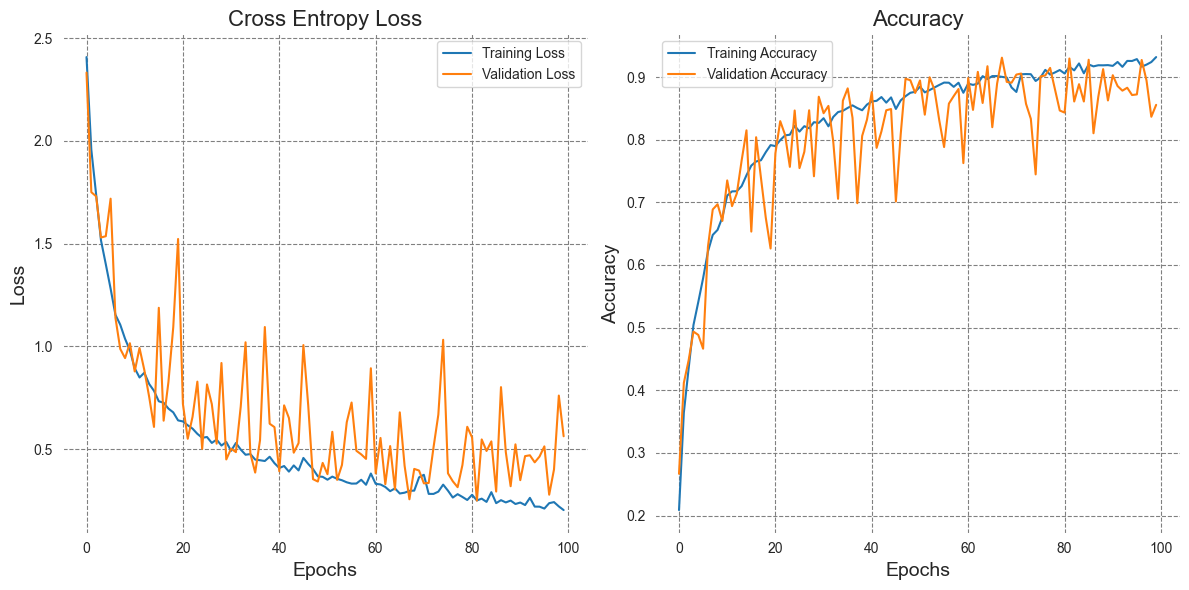

Final Training Loss: 0.2031
Final Training Accuracy: 0.9320
Final Validation Loss: 0.5623
Final Validation Accuracy: 0.8557


In [ ]:
plot_lc(history)
print_loss_acc(history)


: 

##### Final Observations:
We can see that the accuracy is severely improved, going up to above 80% for both validation and training accuracy. The stability in our accuracy is slightly better, with a few anomalies (such as the datapoint close to the 20th epoch and 50th epoch) as compared to the baseline model, but we could not save the cross entropy loss (it is still not too bad, with anomalies evvery 5-10 epochs). We can also see that increasing the layers, allowing it to learn more complex patterns in the pictures, the accuracy is able to increase compared ot the baseline model. To conclude, through the sequential model and improvements such as data augmentation, Learning rate scheduling and adding layers. We can also see that data augmentatiojn is keeping overfitting in check, as the loss and accuracy for both validation and training do not stray away from each other.

<hr>

# References

Dataset: <br>
https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset <br>

Sources: <br>
https://www.upgrad.com/blog/basic-cnn-architecture/ <br>
https://datagen.tech/guides/computer-vision/cnn-convolutional-neural-network/#:~:text=Deep%20learning%20applications%20often%20use,and%20produce%20highly%20accurate%20predictions.<br>
https://journalofbigdata.springeropen.com/articles/10.1186/s40537-021-00444-8<br>
https://pyimagesearch.com/2021/05/14/convolutional-neural-networks-cnns-and-layer-types/<br>
https://medium.com/@draj0718/convolutional-neural-networks-cnn-architectures-explained-716fb197b243<br>
https://towardsdatascience.com/the-dying-relu-problem-clearly-explained-42d0c54e0d24<br>
https://medium.com/mlearning-ai/demystifying-batch-normalization-vs-drop-out-1c8310d9b516<br>
https://www.baeldung.com/cs/ml-relu-dropout-layers <br>
https://towardsdatascience.com/https-medium-com-dashingaditya-rakhecha-understanding-learning-rate-dd5da26bb6de <br>